/var/folders/4d/14nkpqsn4zs8c1dmkl0p4mxr0000gp/T/ipykernel_4526/3253154227.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = df.groupby('age_group')['Survived'].count()
/var/folders/4d/14nkpqsn4zs8c1dmkl0p4mxr0000gp/T/ipykernel_4526/3253154227.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  survived_counts = df.groupby('age_group')['Survived'].sum()


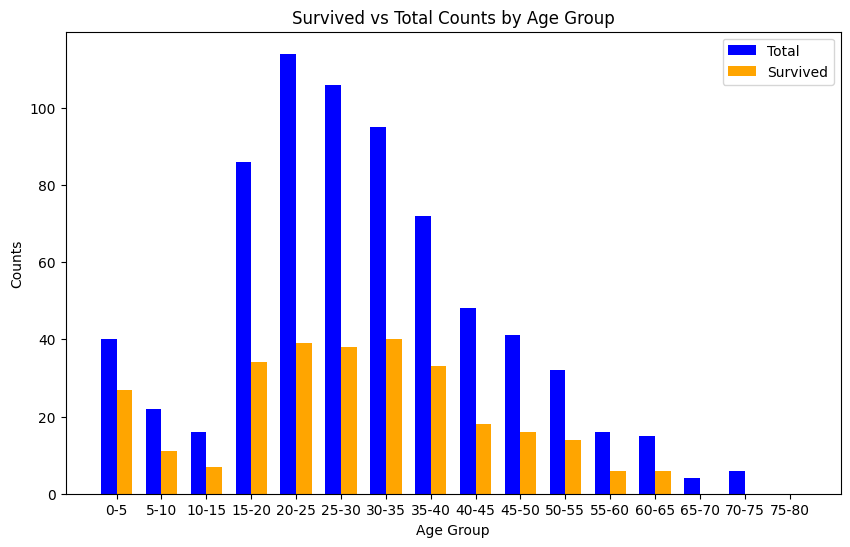

In [192]:
"""
估计 Titanic 乘客生还率
https://www.kaggle.com/competitions/titanic/overview

score: 0.76794
训练 loss: 0.4496934115886688
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


"""
- PassengerId 乘客ID
- Ticket 票号
- Name 姓名
- Cabin 船舱号(类似于高铁的座位号)
- Fare 票价 (该特征和 Pclass 有关， 所以只需要保留一个)
"""

"""
类别特征:
- Pclass: 1, 2, 3 (分别表示一等座, 二等座, 三等座)
- Sex: male, female
- Embarked: 登船港口, C = Cherbourg, Q = Queenstown, S = Southampton
"""

df = pd.read_csv('./data/train.csv')
age_avg = df['Age'].mean()


def clear_data(X):
    X = X.copy()
    X['FamilySize'] = X['SibSp'] + X['Parch'] + 1  # 家庭成员数
    X['IsAlone'] = (X['FamilySize'] == 1).astype(np.int8)  # 是否独自一人

    X['Embarked'] = X['Embarked'].fillna(
        X['Embarked'].mode()[0])

    age_bins = range(0, 85, 10)  # 从 0 到 100，每 5 岁一个区间
    X['Age'] = X['Age'].fillna(age_avg)
    X['age_group'] = pd.cut(X['Age'], bins=age_bins, right=False)
    X = X[['Pclass', 'Sex', 'IsAlone', 'age_group', 'Embarked']]
    X = pd.get_dummies(
        X, columns=['Pclass', 'Sex', 'age_group', 'Embarked'], drop_first=False, dtype=np.int8)

    return X


def get_age_labels(age_bins_range):
    age_labels = []
    for i in range(0, len(age_bins_range) - 1):
        age_labels.append(f'{age_bins_range[i]}-{age_bins_range[i+1]}')
    return age_labels


# 设定划分年龄的区间
age_bins = range(0, 85, 5)  # 从 0 到 100，每 5 岁一个区间
age_labels = get_age_labels(age_bins)
df['age_group'] = pd.cut(df['Age'], bins=age_bins,
                         labels=age_labels, right=False)

y = df['Survived']
X_train = clear_data(df)

# 按年龄段统计患病总数
total_counts = df.groupby('age_group')['Survived'].count()
survived_counts = df.groupby('age_group')['Survived'].sum()

# 设置条形图的宽度
bar_width = 0.35

# 创建图形对象
fig, ax = plt.subplots(figsize=(10, 6))

# 设置条形图的 x 轴位置
index = np.arange(len(age_labels))

# 绘制两个数据系列的条形图
rects1 = ax.bar(index, total_counts,
                bar_width, label='Total', color='blue')
rects2 = ax.bar(index + bar_width, survived_counts, bar_width,
                label='Survived', color='orange')

# 添加标签、标题和图例
ax.set_xlabel('Age Group')
ax.set_ylabel('Counts')
ax.set_title('Survived vs Total Counts by Age Group')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(age_labels)
ax.legend()

# 显示图形
plt.show()

In [126]:
(df[df['Sex'] == 'female']['Survived'].sum()) / len(df[df['Sex'] == 'female']
                                                    ), (df[df['Sex'] == 'male']['Survived'].sum()) / len(df[df['Sex'] == 'male'])

(0.7420382165605095, 0.18890814558058924)

In [194]:
import torch
import torch.nn as nn
import math


class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.fc1 = nn.Linear(input_dim, 10)
        self.fc2 = nn.Linear(10, 8)
        self.fc3 = nn.Linear(8, 1)

    def forward(self, x):
        z1 = self.fc1(x)
        a1 = torch.sigmoid(z1)
        z2 = self.fc2(a1)
        a2 = torch.sigmoid(z2)
        y = self.fc3(a2)
        return y


n_features = X_train.shape[1]
model = LogisticRegression(n_features)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criteria = nn.BCEWithLogitsLoss()  # Binary Cross Entropy Loss

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(
    y.values, dtype=torch.float32).view(-1, 1)  # view(-1, 1) 将 y 变成列向量

for i in range(20000):
    optimizer.zero_grad()
    y_pred = model(X_train_tensor)
    loss = criteria(y_pred, y_train_tensor)
    loss.backward()
    optimizer.step()

    if i % 1000 == 0:
        print(
            f'Iteration {i}, loss: {loss.item()}, prop: {math.exp(-loss.item())}')

Iteration 0, loss: 0.6963561773300171, prop: 0.4983980732784763
Iteration 1000, loss: 0.3530341386795044, prop: 0.7025532087290142
Iteration 2000, loss: 0.3456820249557495, prop: 0.7077374941923203
Iteration 3000, loss: 0.34517037868499756, prop: 0.7080996980941314
Iteration 4000, loss: 0.3451484739780426, prop: 0.7081152089803932
Iteration 5000, loss: 0.34503695368766785, prop: 0.708194182597616
Iteration 6000, loss: 0.34502023458480835, prop: 0.7082060230679801
Iteration 7000, loss: 0.34501078724861145, prop: 0.7082127137599812
Iteration 8000, loss: 0.3450048863887787, prop: 0.708216892836267
Iteration 9000, loss: 0.3450116813182831, prop: 0.7082120805687558
Iteration 10000, loss: 0.3449976146221161, prop: 0.708222042842983
Iteration 11000, loss: 0.3449968099594116, prop: 0.7082226127230766
Iteration 12000, loss: 0.3450947403907776, prop: 0.7081532595730569
Iteration 13000, loss: 0.3449925482273102, prop: 0.7082256309845517
Iteration 14000, loss: 0.34499141573905945, prop: 0.70822643

In [131]:
import pandas as pd

X_test_origin = pd.read_csv('./data/test.csv')
X_test = clear_data(X_test_origin)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

model.eval()
y_pred = model(X_test_tensor).detach().numpy()
y_pred = np.where(y_pred > 0.5, 1, 0)

# 将 X_test_origin 中的 PassengerId 列 和 y_pred 合并
result = pd.DataFrame({
    'PassengerId': X_test_origin['PassengerId'].to_list(),
    'Survived': y_pred.flatten()
}, columns=['PassengerId', 'Survived'])
result.to_csv('./data/result.csv', index=False)